Dashboard für die Fertigung. Zeigt die OEE, Ausschussrate, Variantenverteilung, sowie die Verteilung der Durchlaufzeiten der Varianten

        Charge  bmg              ankunft       start_ruesten  \
0     20000000  RTL  2024-01-01 06:00:54                 NaT   
1     20000001  RTL  2024-01-01 06:00:54                 NaT   
2     20000002  RTL  2024-01-01 06:00:54                 NaT   
3     20000003  RTL  2024-01-01 06:00:54                 NaT   
4     20000004  RTL  2024-01-01 06:00:54                 NaT   
...        ...  ...                  ...                 ...   
7915  20001504  FTL  2024-12-31 17:39:24                 NaT   
7916  20001647  FRA  2024-12-31 09:30:24 2024-12-31 13:23:24   
7917  20001506  HAE  2024-12-31 08:53:36 2024-12-31 14:05:36   
7918  20001506  QPR  2024-12-31 18:49:36 2024-12-31 18:49:36   
7919  20001506  FTL  2024-12-31 21:24:24                 NaT   

        start_bearbeitung    ende_bearbeitung          abtransport  \
0                    None                 NaT                 None   
1                    None                 NaT                 None   
2                    

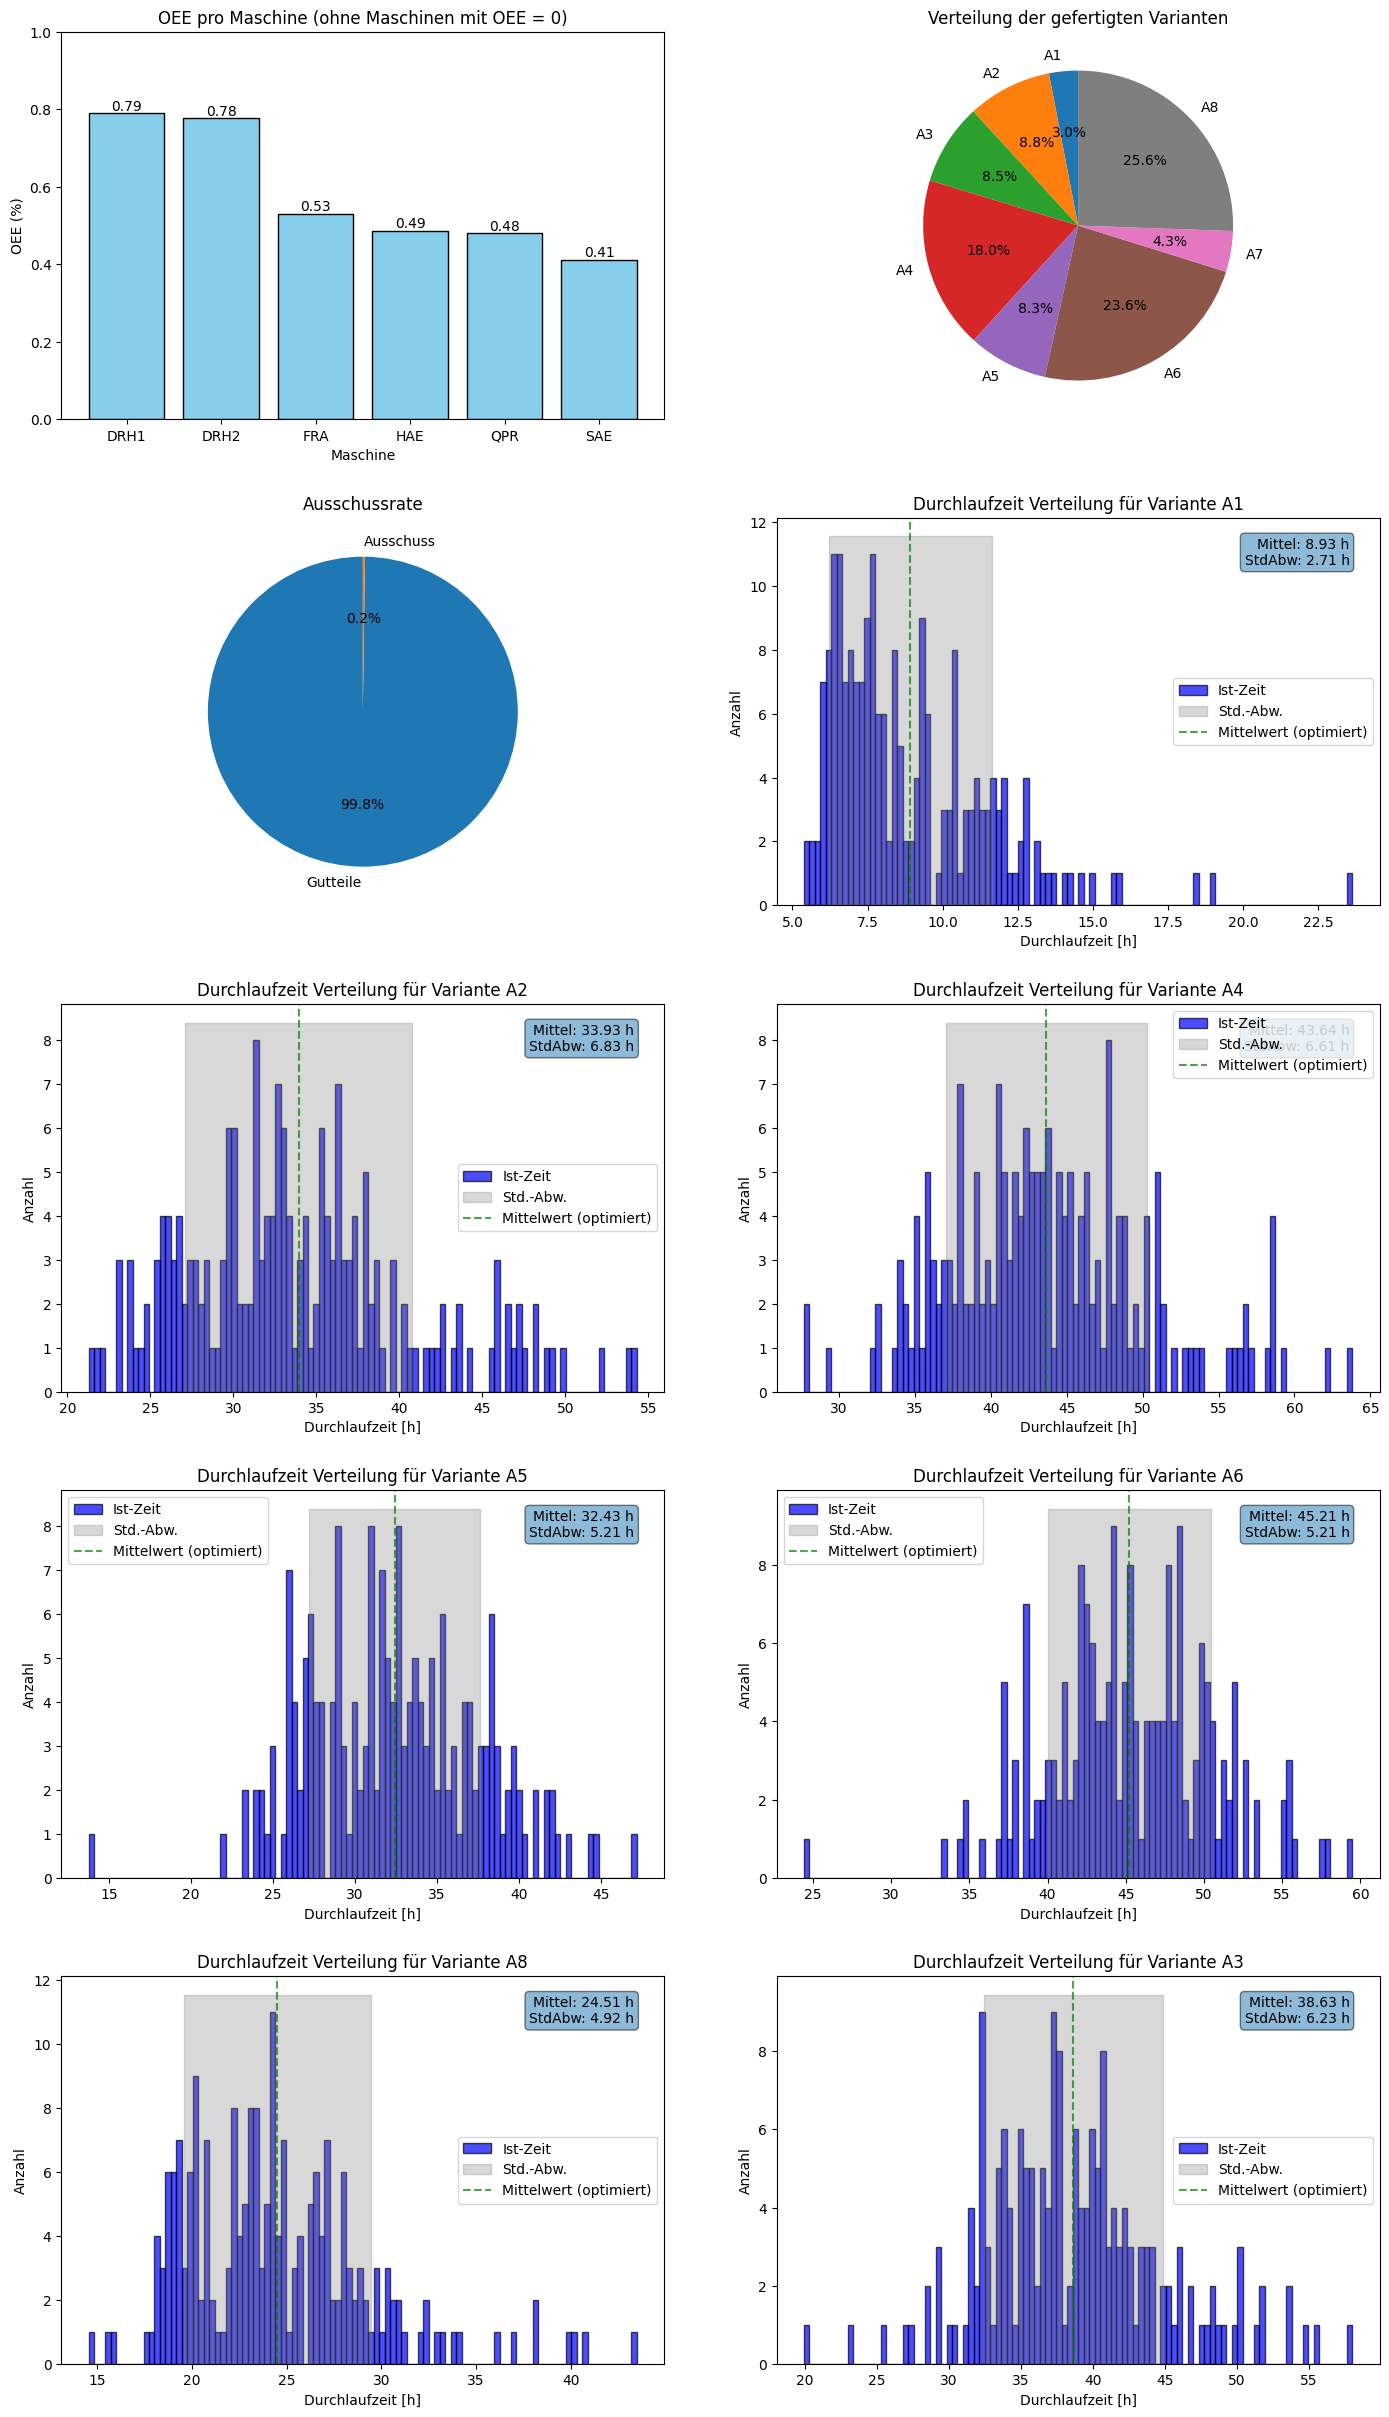

In [2]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Verbindung zur Datenbank herstellen
db_path = "prod_data.db"
verbindung = sqlite3.connect(db_path)

# Maschinen dynamisch aus der Datenbank abrufen
maschinen_query = "SELECT DISTINCT bmg FROM FLF"
maschinen = pd.read_sql_query(maschinen_query, verbindung)['bmg'].tolist()

# Varianten dynamisch aus der Datenbank abrufen
varianten_query = "SELECT DISTINCT id FROM auftraege"
varianten = pd.read_sql_query(varianten_query, verbindung)['id'].tolist()

# Daten aus der Datenbank abrufen
flf_df = pd.read_sql_query("SELECT * FROM FLF", verbindung)
auftraege_df = pd.read_sql_query("SELECT * FROM auftraege", verbindung)
auftraege_df2 = pd.read_sql_query("SELECT * FROM auftraege WHERE fertigstellung IS NOT NULL", verbindung)
elf_df = pd.read_sql_query("SELECT * FROM ELF", verbindung)
arbeitsplaene_df = pd.read_sql_query("SELECT * FROM arbeitsplaene",verbindung)

# Daten aufbereiten
flf_df['Charge'] = flf_df['Charge'].astype(str)
auftraege_df['Charge'] = auftraege_df['Charge'].astype(str)

auftraege_df = auftraege_df.merge(flf_df[['Charge', 'bmg']], on='Charge', how='inner')

# Nur relevante Maschinen und Varianten
auftraege_df = auftraege_df[auftraege_df['bmg'].isin(maschinen)]
elf_df = elf_df[elf_df['bmg'].isin(maschinen)]
flf_df = flf_df[flf_df['bmg'].isin(maschinen)]

# Zeitspalten konvertieren
auftraege_df['freigabe'] = pd.to_datetime(auftraege_df['freigabe'], errors='coerce')
auftraege_df['fertigstellung'] = pd.to_datetime(auftraege_df['fertigstellung'], errors='coerce')
elf_df['start_downtime'] = pd.to_datetime(elf_df['start_downtime'], errors='coerce')
elf_df['end_downtime'] = pd.to_datetime(elf_df['end_downtime'], errors='coerce')

flf_df['start_ruesten'] = pd.to_datetime(flf_df['start_ruesten'], errors='coerce')
flf_df['ende_bearbeitung'] = pd.to_datetime(flf_df['ende_bearbeitung'], errors='coerce')

auftraege_df2['freigabe'] = pd.to_datetime(auftraege_df2['freigabe'], errors='coerce')
auftraege_df2['fertigstellung'] = pd.to_datetime(auftraege_df2['fertigstellung'], errors='coerce')

auftraege_df2['production_time'] = (auftraege_df2['fertigstellung'] - auftraege_df2['freigabe']).dt.total_seconds().fillna(0)

print(flf_df)

# Produktionszeit und Downtime berechnen
auftraege_df['production_time'] = (auftraege_df['fertigstellung'] - auftraege_df['freigabe']).dt.total_seconds().fillna(0)
 # Planzeiten hinzufügen
flf_df['production_time']=(flf_df['ende_bearbeitung'] - flf_df['start_ruesten']).dt.total_seconds().fillna(0)
print(flf_df)

import pandas as pd

def entferne_stillstandszeiten(row):
    """
    Zieht für jeden Tag zwischen start_ruesten und ende_bearbeitung 6 Stunden (21600 Sekunden) ab,
    wenn die Produktionszeit mehrere Tage umfasst.
    """
    start_time = row['start_ruesten']
    end_time = row['ende_bearbeitung']
    
    if pd.isna(start_time) or pd.isna(end_time):
        return 0  # Rückgabe von 0 für ungültige Einträge
    
    # Berechne die Produktionszeit in Sekunden
    production_time = (end_time - start_time).total_seconds()
    
    # Berechne die Anzahl der Tage zwischen Start- und Endzeit
    days_diff = (end_time.date() - start_time.date()).days
    
    # Wenn die Zeitspanne mehrere Tage umfasst, für jeden Tag 6 Stunden abziehen
    if days_diff > 0:
        production_time -= (days_diff + 1) * 21600  # 6 Stunden pro Tag in Sekunden (einschließlich Start- und Endtag)

    return max(production_time, 0)  # Sicherstellen, dass keine negativen Werte zurückgegeben werden

# Angepasste Produktionszeit mit Abzug der Stillstandszeit berechnen
flf_df['adjusted_production_time'] = flf_df.apply(entferne_stillstandszeiten, axis=1)

# Produktionszeiten prüfen
print(flf_df[['start_ruesten', 'ende_bearbeitung', 'adjusted_production_time']])


arbeitsplaene_df['planzeit'] = ((arbeitsplaene_df['r_plan'] + (arbeitsplaene_df['t_plan']*auftraege_df['stueckzahl_plan']))/60)
planzeit_pro_variante = arbeitsplaene_df.groupby('id')['planzeit'].sum()

# Planzeiten den Aufträgen zuordnen
auftraege_df = auftraege_df.merge(planzeit_pro_variante, on='id', how='left')


def berechne_anzahl_tage(startzeiten, endzeiten):
    """
    Berechnet die Anzahl der Tage im Betrachtungszeitraum basierend auf den minimalen und maximalen Daten.
    """
    startdatum = min(startzeiten.min(), endzeiten.min())
    enddatum = max(startzeiten.max(), endzeiten.max())
    return (enddatum - startdatum).days

# Verfügbare Zeit pro Maschine berechnen
anzahl_tage = berechne_anzahl_tage(flf_df['start_ruesten'], flf_df['ende_bearbeitung'])
gesamt_verfuegbare_zeit = 57600 * anzahl_tage  # 57.600 Sekunden pro Tag * Anzahl der Tage

auftraege_df = auftraege_df.merge(flf_df[['Charge', 'bmg', 'adjusted_production_time']], on='Charge', how='inner')

#print(auftraege_df)

elf_df['downtime'] = (elf_df['end_downtime'] - elf_df['start_downtime']).dt.total_seconds().fillna(0)

# OEE-Berechnungen
production_time_per_machine = flf_df.groupby('bmg')['adjusted_production_time'].sum()
downtime_per_machine = elf_df.groupby('bmg')['downtime'].sum()
downtime_per_machine = downtime_per_machine.reindex(maschinen, fill_value=0)
availabel_time = ((gesamt_verfuegbare_zeit- downtime_per_machine))
#Nutzungsfaktor             geplante Produktionszeit            Betriebsdauer 
availability_per_machine = (availabel_time/ gesamt_verfuegbare_zeit).fillna(0)

flf_df['good_parts'] = flf_df['anzahl_bauteile'] - flf_df['ausschuss']

#Qualitätsfaktor            Gutmenge                               / Produzierte Menge  :check
quality_per_machine = (flf_df.groupby('bmg')['good_parts'].sum() / flf_df.groupby('bmg')['anzahl_bauteile'].sum()).fillna(0)

#Effizienfaktor                         Produzierten Menge / (Betreibsdauer * theoretische Laufzeit)
auftraege_df['cycle_performance'] = auftraege_df['stueckzahl_ist'] / auftraege_df['stueckzahl_plan']

performance_per_machine = (production_time_per_machine / availabel_time) #Beschreibt das bis jetzt das Gleich wie die Quality_per_machine

oee_per_machine = (availability_per_machine * performance_per_machine * quality_per_machine).fillna(0)


print(availabel_time)
print(production_time_per_machine)

print("Verfügbarkeit pro Maschine:\n", availability_per_machine)
print("Qualität pro Maschine:\n", quality_per_machine)
print("Leistung pro Maschine:\n", performance_per_machine)
print("OEE pro Maschine:\n", oee_per_machine)

#test ------------------------


def entferne_stillstandszeiten_varianten(row):
    """
    Zieht für jeden Arbeitstag 6 Stunden (21600 Sekunden) ab,
    wenn die Produktionszeit mehrere Tage umfasst. Zusätzlich werden 48 Stunden (172800 Sekunden)
    für Wochenenden abgezogen, ohne Doppelberücksichtigung.
    """
    start_time2 = row['freigabe']
    end_time2 = row['fertigstellung']
    
    if pd.isna(start_time2) or pd.isna(end_time2):
        return 0  # Rückgabe von 0 für ungültige Einträge
    
    # Berechne die Produktionszeit in Sekunden
    production_time2 = (end_time2 - start_time2).total_seconds()
    

    # Berechne die Anzahl der Tage zwischen Start- und Endzeit
    days_diff2  = (end_time2.date() - start_time2.date()).days
    
    print(days_diff2)

    # Ziehe 6 Stunden pro Arbeitstag ab (ohne Wochenendtage)
    current_date = start_time2.date()

    if current_date.weekday() not in [5, 6] and days_diff2 > 0:  # Kein Samstag oder Sonntag
        production_time2 -= days_diff2 * 21600  # 6 Stunden in Sekunden
        
    
    # Ziehe zusätzlich 48 Stunden für jedes Wochenende im Zeitraum ab
    current_date = start_time2.date()
    while current_date <= end_time2.date():
        if current_date.weekday() in [5, 6]:  # Samstag oder Sonntag
            production_time2 -= 115200  # 48 Stunden in Sekunden
            break  # Abbruch nach erstem gefundenen Wochenende, da 48h für das gesamte Wochenende gelten
        current_date += pd.Timedelta(days=1)
    
    return max(production_time2, 0)  # Sicherstellen, dass keine negativen Werte zurückgegeben werden



auftraege_df2['optimized_production_time'] = auftraege_df2.apply(entferne_stillstandszeiten_varianten, axis=1)


print(auftraege_df2)
print(auftraege_df2['optimized_production_time'])




# Ausschuss berechnen
ausschuss = (flf_df.groupby('bmg')['anzahl_bauteile'].sum() - flf_df.groupby('bmg')['good_parts'].sum())

# Variablen für Tortendiagramme vorbereiten
gesamtstückzahl = auftraege_df['stueckzahl_ist'].sum()
stückzahlen_pro_variante = auftraege_df.groupby('id')['stueckzahl_ist'].sum()
ausschuss_gesamt = flf_df['ausschuss'].sum()
gutteile_gesamt = gesamtstückzahl - ausschuss_gesamt

# --- Dashboard ---
import math

# Gesamtanzahl der Diagramme
total_plots = len(maschinen) + 2  # OEE + Ausschuss + Variantenverteilung + Maschinen-Histogramme

# Anzahl der Zeilen für 2 Spalten
rows = math.ceil(total_plots / 2)

# Neues Subplot-Layout
fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))
fig.tight_layout(pad=5.0)

# Flache Liste der Achsen für einfachere Zuordnung
axs = axs.flatten()

# OEE pro Maschine darstellen (ohne Maschinen mit OEE = 0)
oee_per_machine_filtered = oee_per_machine[oee_per_machine > 0]  # Nur Maschinen mit OEE > 0

# Balkendiagramm für OEE
axs[0].bar(oee_per_machine_filtered.index, oee_per_machine_filtered.values, color='skyblue', edgecolor='black')

# Hinzufügen von Text für die OEE-Werte
for bar in axs[0].patches:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Diagramm-Details
axs[0].set_title("OEE pro Maschine (ohne Maschinen mit OEE = 0)")
axs[0].set_xlabel("Maschine")
axs[0].set_ylabel("OEE (%)")
axs[0].set_ylim(0, 1)


# Tortendiagramm: Verteilung der Varianten
axs[1].pie(stückzahlen_pro_variante, labels=stückzahlen_pro_variante.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title("Verteilung der gefertigten Varianten")

# Tortendiagramm: Ausschussrate
axs[2].pie([gutteile_gesamt, ausschuss_gesamt], labels=['Gutteile', 'Ausschuss'], autopct='%1.1f%%', startangle=90)
axs[2].set_title("Ausschussrate")





# Produktionszeit in Minuten umrechnen für Histogramme
auftraege_df2['optimized_production_time_minutes'] = auftraege_df2['optimized_production_time'] /3600

print(auftraege_df2['optimized_production_time_minutes'])

# Histogramme für Durchlaufzeiten (Maschinen-spezifisch) mit optimierten Zeiten
for idx, variante in enumerate(varianten):
    variante_data = auftraege_df2[auftraege_df2['id'] == variante]
    if idx + 3 < len(axs):  # Verhindern, dass wir außerhalb des Achsenbereichs schreiben
        # Optimierte Durchlaufzeiten
        production_time_minutes = variante_data['optimized_production_time_minutes']
        
        # Mittlere optimierte Durchlaufzeit und Standardabweichung berechnen
        mean_time = production_time_minutes.mean()
        std_dev = production_time_minutes.std()

        # Histogramm
        axs[idx + 3].hist(production_time_minutes, bins=100, color='blue', edgecolor='black', alpha=0.7, label='Ist-Zeit')

        # Planzeit-Linie hinzufügen (optional)
        #if not variante_data['planzeit'].isna().all():  # Sicherstellen, dass es Planzeiten gibt
            #planzeit_mean_minutes = variante_data['planzeit'].mean()   # Planzeit in Minuten
            #axs[idx + 3].axvline(planzeit_mean_minutes, color='orange', alpha=0.7, label='Planzeit')
        
        # Grauer Balken für den Bereich der Standardabweichung
        axs[idx + 3].fill_betweenx(
            y=[0, axs[idx + 3].get_ylim()[1]],  # Fülle von 0 bis Maximalhöhe des Diagramms
            x1=mean_time - std_dev,
            x2=mean_time + std_dev,
            color='grey',
            alpha=0.3,
            label='Std.-Abw.'
        )

        # Mittlere optimierte Durchlaufzeit als Linie
        axs[idx + 3].axvline(mean_time, color='green', linestyle='--', alpha=0.7, label='Mittelwert (optimiert)')

        # Mittlere Durchlaufzeit und Standardabweichung als Text
        axs[idx + 3].text(0.95, 0.95, f'Mittel: {mean_time:.2f} h\nStdAbw: {std_dev:.2f} h',
                          transform=axs[idx + 3].transAxes, fontsize=10,
                          verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", alpha=0.5))

        # Achsentitel und Legende
        axs[idx + 3].set_title(f"Durchlaufzeit Verteilung für Variante {variante}")
        axs[idx + 3].set_xlabel("Durchlaufzeit [h]")  # Achsentitel angepasst
        axs[idx + 3].set_ylabel("Anzahl")
        axs[idx + 3].legend()


# Entfernen von leeren Subplots
for i in range(total_plots, len(axs)):
    fig.delaxes(axs[i])

# Diagramme anzeigen
plt.show()







Durchlaufdiagramm für die gesamte Fertigung 

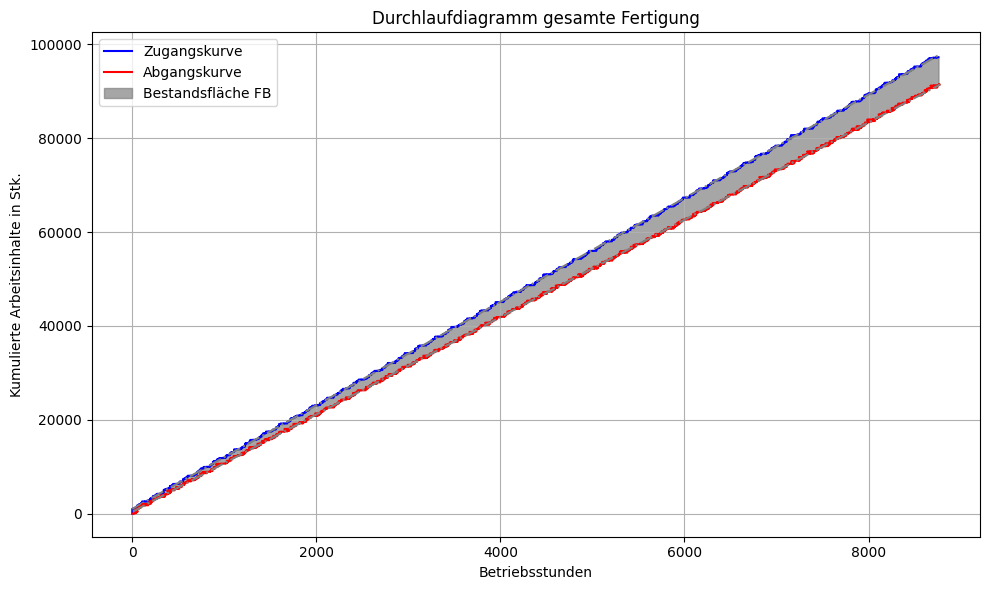

In [4]:
#Durchlaufdiagramm für die gesamte Fertigung

import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
import scipy


#Menge an geplotten Daten
laenge = 10000

#Verschiebeung von Abgangskurve nach hinten um Stunden
h = 0

# Verbindung zur Datenbank herstellen
verbindung = sqlite3.connect("prod_data.db")
zeiger = verbindung.cursor()


def berechne_betriebs_stunden(zeitpunkt, start_datum):
    """Berechnet die Betriebsstunden seit dem ersten Produktionstag"""
    return (zeitpunkt - start_datum).total_seconds() / 3600  # Umrechnung von Sekunden in Stunden

zeiger.execute(f"SELECT freigabe, fertigstellung, stueckzahl_plan, stueckzahl_ist FROM auftraege WHERE fertigstellung IS NOT NULL ORDER BY freigabe ASC")
daten = zeiger.fetchall()
    

# Umwandeln der Daten in datetime-Objekte und sicherstellen, dass keine None-Werte enthalten sind
ankunft_liste = []
fertigstellung_liste = []
vorgabe_liste = []
real_liste = []
    
for e in daten:
    # Wenn die Werte nicht None sind, führe das Parsing durch
    if e[0] is not None and e[1] is not None:
        ankunft_liste.append(datetime.strptime(e[0], '%Y-%m-%d %H:%M:%S'))
        fertigstellung_liste.append(datetime.strptime(e[1], '%Y-%m-%d %H:%M:%S'))
        vorgabe_liste.append(int(e[2]))  
        real_liste.append(int(e[3]))# Vorgabe ist der Arbeitsinhalt

fertigstellung_liste = [e + timedelta(hours=h) for e in fertigstellung_liste]
    
# Prüfen, ob die Listen leer sind, bevor wir mit min() fortfahren
if not ankunft_liste:
    print(f"Keine gültigen Startzeiten für Maschine gefunden.")
    
# Berechnen des ersten Produktionsdatums
start_datum = min(ankunft_liste)
    
# Berechnen der Betriebsstunden für Zugang und Abgang
zugang_stunden = [berechne_betriebs_stunden(e, start_datum) for e in ankunft_liste]
abgang_stunden = [berechne_betriebs_stunden(e, start_datum) for e in fertigstellung_liste]
    
# Kumulative Summe für die Zugangskurve und Abgangskurve
kumulierte_zugang = [sum(vorgabe_liste[:i+1]) for i in range(len(vorgabe_liste))]
kumulierte_abgang = [sum(real_liste[:i+1]) for i in range(len(real_liste))]

#lineare Regression für beide Kurven 

X_zugang = np.array(zugang_stunden).reshape(-1, 1)
y_zugang = np.array(kumulierte_zugang)

X_abgang = np.array(abgang_stunden).reshape(-1, 1)
y_abgang = np.array(kumulierte_abgang)

model_zugang = LinearRegression().fit(X_zugang, y_zugang)
zugang_prognose = model_zugang.predict(X_zugang)

model_abgang = LinearRegression().fit(X_abgang, y_abgang)
abgang_prognose = model_abgang.predict(X_abgang)

bestand = [kumulierte_zugang[i] - kumulierte_abgang[i] for i in range(len(kumulierte_zugang))]

#debugging


#print(kumulierte_zugang_interp[0])

P = max(abgang_stunden) - min(zugang_stunden)  # Bezugzeitraum in Stunden
Bm = sum(vorgabe_liste) / len(vorgabe_liste)  # Durchschnittlicher Bestand
Rm = Bm / (P / len(zugang_stunden))  # Mittlere Reichweite
Lm = kumulierte_abgang[-1] / P  # Mittlere Leistung

#zugang_stunden_multipliziert = [Lm * z for z in zugang_stunden]
 #abgang_stunden_multipliziert = [Lm * a for a in abgang_stunden]

# Alternativ mit numpy
zugang_stunden_multipliziert = np.array(zugang_stunden) * Lm
abgang_stunden_multipliziert = np.array(abgang_stunden) * Lm
  

#y = Lm * zugang_stunden

# Visualisierung des Diagramms für die Maschine
fig, ax = plt.subplots(figsize=(10, 6))
    
# Zugangskurve (blau)
ax.step(zugang_stunden[:laenge], kumulierte_zugang[:laenge], label='Zugangskurve', color='blue', where='mid')
#ax.plot(zugang_stunden[:laenge], zugang_stunden_multipliziert[:laenge], color = 'gray', linestyle='--')
ax.plot(zugang_stunden[:laenge], zugang_prognose[:laenge], color='grey', linestyle='dashdot')
    
# Abgangskurve (rot)
ax.step(abgang_stunden[:laenge], kumulierte_abgang[:laenge], label='Abgangskurve', color='red', where='mid')
#ax.plot(abgang_stunden[:laenge], abgang_stunden_multipliziert[:laenge],color = 'gray')
ax.plot(abgang_stunden[:laenge], abgang_prognose[:laenge],color='grey', linestyle='dashdot')

# Mittlerer Bestand als schattierte Fläche zwischen Zugang und Abgang
ax.fill_between(zugang_stunden[:laenge],kumulierte_zugang[:laenge], color='grey', step='mid', alpha=0.7, label='Bestandsfläche FB')
ax.fill_between(abgang_stunden[:laenge], kumulierte_abgang[:laenge], color='white', step='mid',interpolate= False, alpha=1)

    
# Linien für die mittleren Werte
#ax.axhline(Bm, color='green', linestyle='--', label=f'Mittlerer Bestand Bm = {Bm:.2f}')
#ax.axhline(Lm, color='purple', linestyle='--', label=f'Mittlere Leistung Lm = {Lm:.2f}')
#ax.axvline(Rm, color='orange', linestyle='--', label=f'Mittlere Reichweite Rm = {Rm:.2f}')
    
    # Diagrammdetails
ax.set_xlabel("Betriebsstunden")
ax.set_ylabel("Kumulierte Arbeitsinhalte in Stk.")
ax.set_title(f"Durchlaufdiagramm gesamte Fertigung")
ax.legend(loc='upper left')
ax.grid(True)

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

# Verbindung zur Datenbank schließen
verbindung.close()


#Mittlerer Bestand und andere Kennwerte anschauen 

Durchlaufdiagramme für jede einzelne (produzierende) Maschine. Hier muss man jedes Diagramm wieder einzeln schließen damit das nächste erscheint

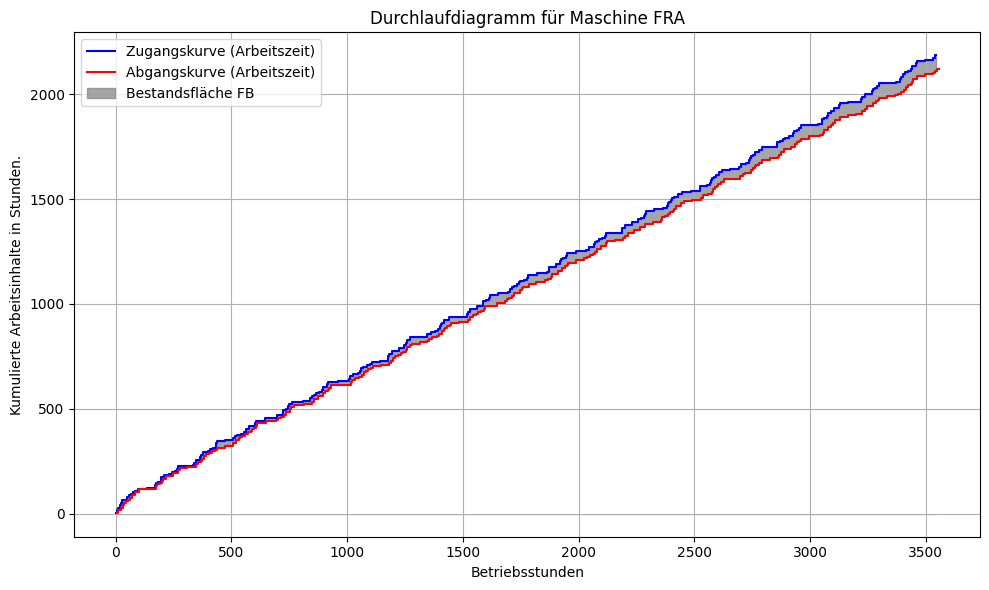

Keine gültigen Startzeiten für Maschine FTL gefunden.


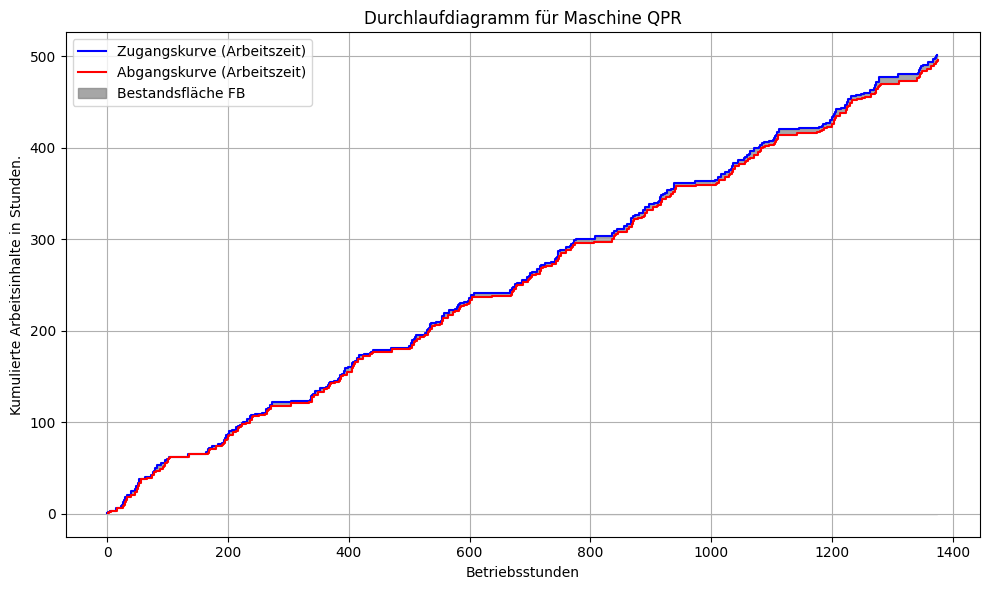

Keine gültigen Startzeiten für Maschine RTL gefunden.


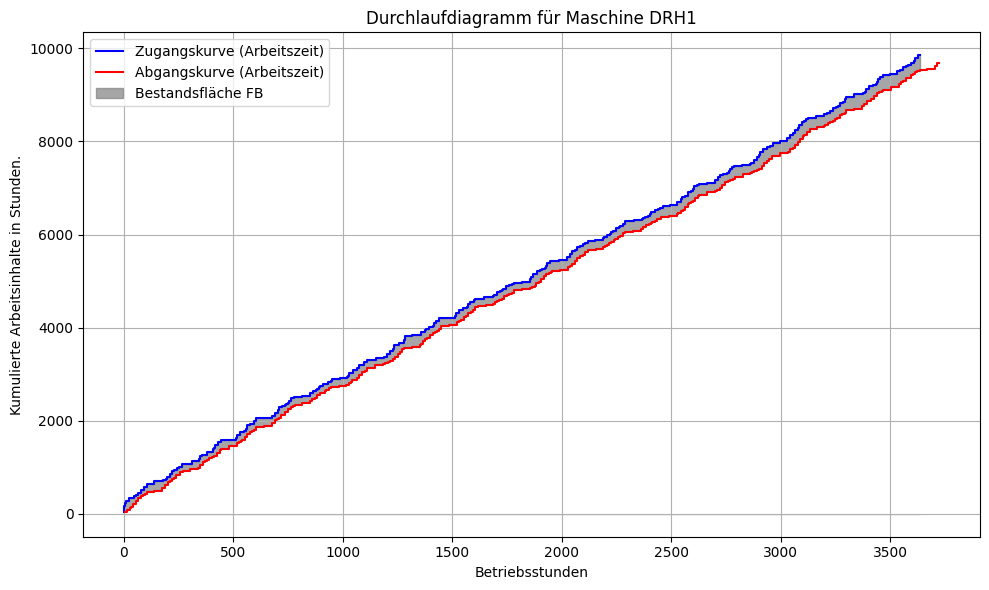

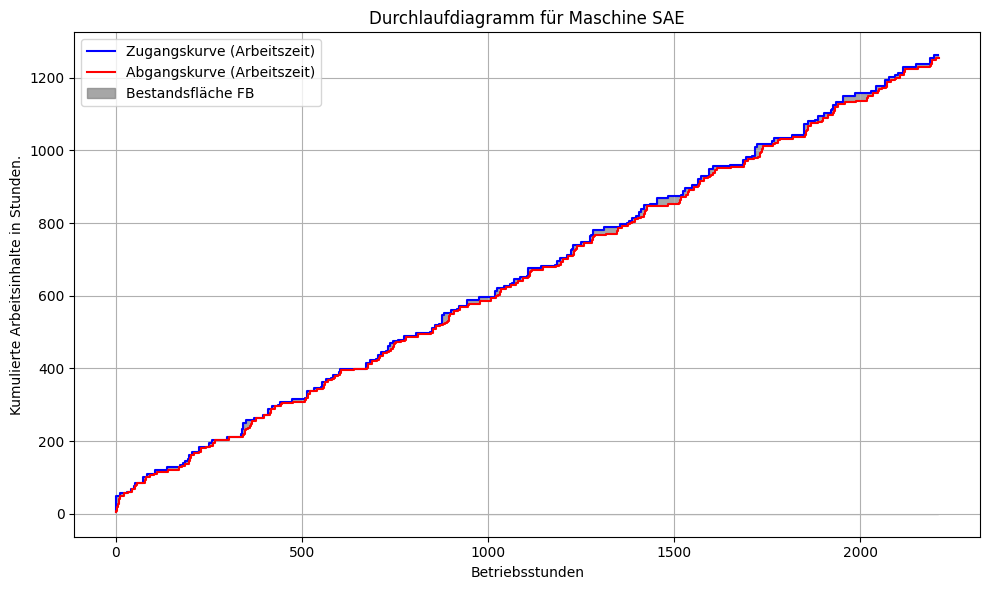

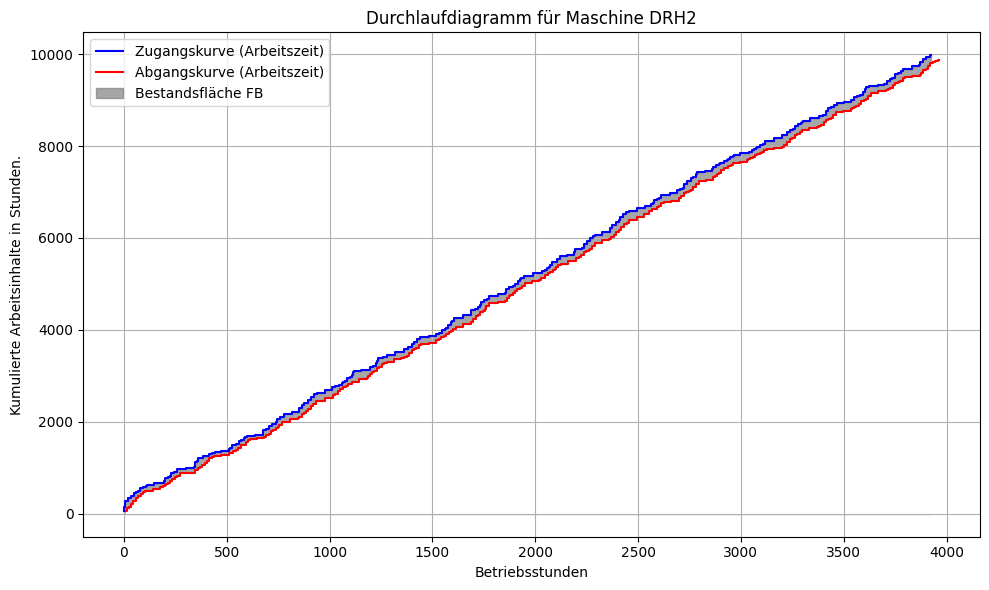

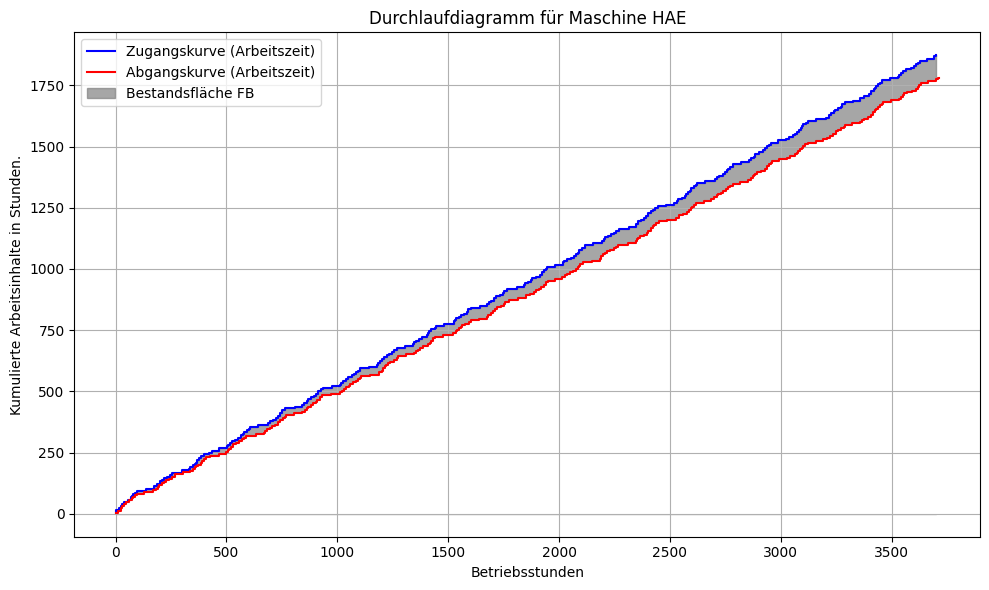

In [2]:

import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math


#Menge an geplotten Daten
laenge = 250

#Verschiebeung von Abgangskurve nach hinten um Stunden
h = 0

# Verbindung zur Datenbank herstellen
verbindung = sqlite3.connect("prod_data.db")
zeiger = verbindung.cursor()

# Abrufen der Maschinen aus der Datenbank
zeiger.execute("SELECT DISTINCT bmg FROM FLF")
maschinen = zeiger.fetchall()

# Funktion zur Berechnung der Betriebsstunden in Stunden seit dem ersten Produktionstag
def berechne_betriebs_stunden(zeitpunkt, start_datum):
    """Berechnet die Betriebsstunden seit dem ersten Produktionstag"""
    return (zeitpunkt - start_datum).total_seconds() / 3600  # Umrechnung von Sekunden in Stunden

# Erstellen eines Diagramms für jede Maschine
for maschine in maschinen:
    maschine_name = maschine[0]
    
    # Daten für die aktuelle Maschine holen
    zeiger.execute(f"SELECT ankunft, ende_bearbeitung, anzahl_bauteile, anzahl_bauteile + ausschuss AS plan FROM FLF WHERE bmg = '{maschine_name}'")
    daten = zeiger.fetchall()
    
    # Umwandeln der Daten in datetime-Objekte und sicherstellen, dass keine None-Werte enthalten sind
    ankunft_liste = []
    fertigstellung_liste = []
    vorgabe_liste = []
    real_liste = []
    
    for e in daten:
        # Wenn die Werte nicht None sind, führe das Parsing durch
        if e[0] is not None and e[1] is not None:
            ankunft_liste.append(datetime.strptime(e[0], '%Y-%m-%d %H:%M:%S'))
            fertigstellung_liste.append(datetime.strptime(e[1], '%Y-%m-%d %H:%M:%S'))
            vorgabe_liste.append(int(e[3])) 
            real_liste.append(int(e[2])) # Vorgabe ist der Arbeitsinhalt

    #verschieben der Abgangskurve um 4 Stunden nach hinten zur besseren Visualiesierung 
    fertigstellung_liste = [e + timedelta(hours=h) for e in fertigstellung_liste]
    
    # Prüfen, ob die Listen leer sind, bevor wir mit min() fortfahren
    if not ankunft_liste:
        print(f"Keine gültigen Startzeiten für Maschine {maschine_name} gefunden.")
        continue
    
    # Berechnen des ersten Produktionsdatums
    start_datum = min(ankunft_liste)
    
    # Berechnen der Betriebsstunden für Zugang und Abgang
    zugang_stunden = [berechne_betriebs_stunden(e, start_datum) for e in ankunft_liste]
    abgang_stunden = [berechne_betriebs_stunden(e, start_datum) for e in fertigstellung_liste]

    zugang_stunden.sort()
    abgang_stunden.sort()
    
    # Kumulative Summe für die Zugangskurve und Abgangskurve
    kumulierte_zugang = [sum(vorgabe_liste[:i+1]) for i in range(len(vorgabe_liste))]
    kumulierte_abgang = [sum(real_liste[:i+1]) for i in range(len(real_liste))]

    # Berechnung der Produktionsrate
    produktionsraten = []
    for i in range(len(daten)):
     if daten[i][0] is not None and daten[i][1] is not None and daten[i][2] > 0:
            zeitdifferenz = (datetime.strptime(daten[i][1], '%Y-%m-%d %H:%M:%S') - datetime.strptime(daten[i][0], '%Y-%m-%d %H:%M:%S')).total_seconds() / 3600
            if zeitdifferenz > 0:  # Schutz gegen Division durch Null
                produktionsraten.append(daten[i][2] / zeitdifferenz)

    # Durchschnittliche Produktionsrate berechnen (fallback falls keine Daten vorliegen)
    if produktionsraten:
        durchschnittliche_produktionsrate = sum(produktionsraten) / len(produktionsraten)
    else:
        print(f"Keine gültige Produktionsraten für Maschine {maschine_name} berechnet.")
        continue

    # Umwandlung von Stückzahlen in kumulierte Arbeitszeiten
    kumulierte_zugang_arbeitszeit = [x / durchschnittliche_produktionsrate for x in kumulierte_zugang]
    kumulierte_abgang_arbeitszeit = [x / durchschnittliche_produktionsrate for x in kumulierte_abgang]

    # Gemeinsame x-Werte für Arbeitszeiten
    #kumulierte_zugang_arbeitszeit_interp = np.interp(gemeinsame_x, zugang_stunden, kumulierte_zugang_arbeitszeit)
    #kumulierte_abgang_arbeitszeit_interp = np.interp(gemeinsame_x, abgang_stunden, kumulierte_abgang_arbeitszeit)

    import numpy as np

    # Gemeinsame x-Werte für Zugang und Abgang finden
    gemeinsame_x = np.union1d(zugang_stunden, abgang_stunden)

    # Interpolierte y-Werte für kumulierte Zugang und Abgang
    #kumulierte_zugang_interp = np.interp(gemeinsame_x, zugang_stunden, kumulierte_zugang)
    #kumulierte_abgang_interp = np.interp(gemeinsame_x, abgang_stunden, kumulierte_abgang)



    #print('Ankunft',ankunft_liste)
    #print(fertigstellung_liste)
    #print (start_datum)
    #print(kumulierte_zugang)
    #print(zugang_stunden[:laenge])
    #print(kumulierte_abgang)
    #print(kumulierte_abgang_interp)
    #print(kumulierte_zugang_interp)



    # Berechnung der mittleren Größen
    P = max(abgang_stunden) - min(zugang_stunden)  # Bezugzeitraum in Stunden
    Bm = sum(vorgabe_liste) / len(vorgabe_liste)  # Durchschnittlicher Bestand
    Rm = Bm / (P / len(zugang_stunden))  # Mittlere Reichweite
    Lm = kumulierte_abgang[-1] / P  # Mittlere Leistung



  

    #y = Lm * zugang_stunden

    # Visualisierung des Diagramms für die Maschine
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Zugangskurve (in Arbeitszeit)
    ax.step(zugang_stunden[:laenge], kumulierte_zugang_arbeitszeit[:laenge], label='Zugangskurve (Arbeitszeit)', color='blue', where='mid')

    # Abgangskurve (in Arbeitszeit)
    ax.step(abgang_stunden[:laenge], kumulierte_abgang_arbeitszeit[:laenge], label='Abgangskurve (Arbeitszeit)', color='red', where='mid')


    # Mittlerer Bestand als schattierte Fläche zwischen Zugang und Abgang
    ax.fill_between(zugang_stunden[:laenge], kumulierte_zugang_arbeitszeit[:laenge], color='grey', step='mid', alpha=0.7, label='Bestandsfläche FB')
    ax.fill_between(abgang_stunden[:laenge], kumulierte_abgang_arbeitszeit[:laenge], color='white', step='mid',interpolate= False, alpha=1)
    
    
    # Linien für die mittleren Werte
    #ax.axhline(Bm, color='green', linestyle='--', label=f'Mittlerer Bestand Bm = {Bm:.2f}')
    #ax.axhline(Lm, color='purple', linestyle='--', label=f'Mittlere Leistung Lm = {Lm:.2f}')
    #ax.axvline(Rm, color='orange', linestyle='--', label=f'Mittlere Reichweite Rm = {Rm:.2f}')
    
    # Diagrammdetails
    ax.set_xlabel("Betriebsstunden")
    ax.set_ylabel("Kumulierte Arbeitsinhalte in Stunden.")
    ax.set_title(f"Durchlaufdiagramm für Maschine {maschine_name}")
    ax.legend(loc='upper left')
    ax.grid(True)

    # Layout anpassen und Diagramm anzeigen
    plt.tight_layout()
    plt.show()

# Verbindung zur Datenbank schließen
verbindung.close()

#Für gesamte Fertigung Freigabeauftrag und Fertigstellung 
#Wenn pro Maschine dann auch Lagermenge davor betrachten 
#ohne Downtimes (Schichtende, Wochenende)



#Funktion mit Angabe Start- und Enddatum 
#Diagramme für Maschinen --> Welcher Aufträge waren auf welchen Maschinen 
#Wie Plantafel für Fertigung 

Plantafel für die Fertigung ohne Stillstandzeiten 

/var/folders/bd/4skfjjdn4dv6rl49dh8758200000gn/T/ipykernel_5226/3192698401.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(unique_charges))


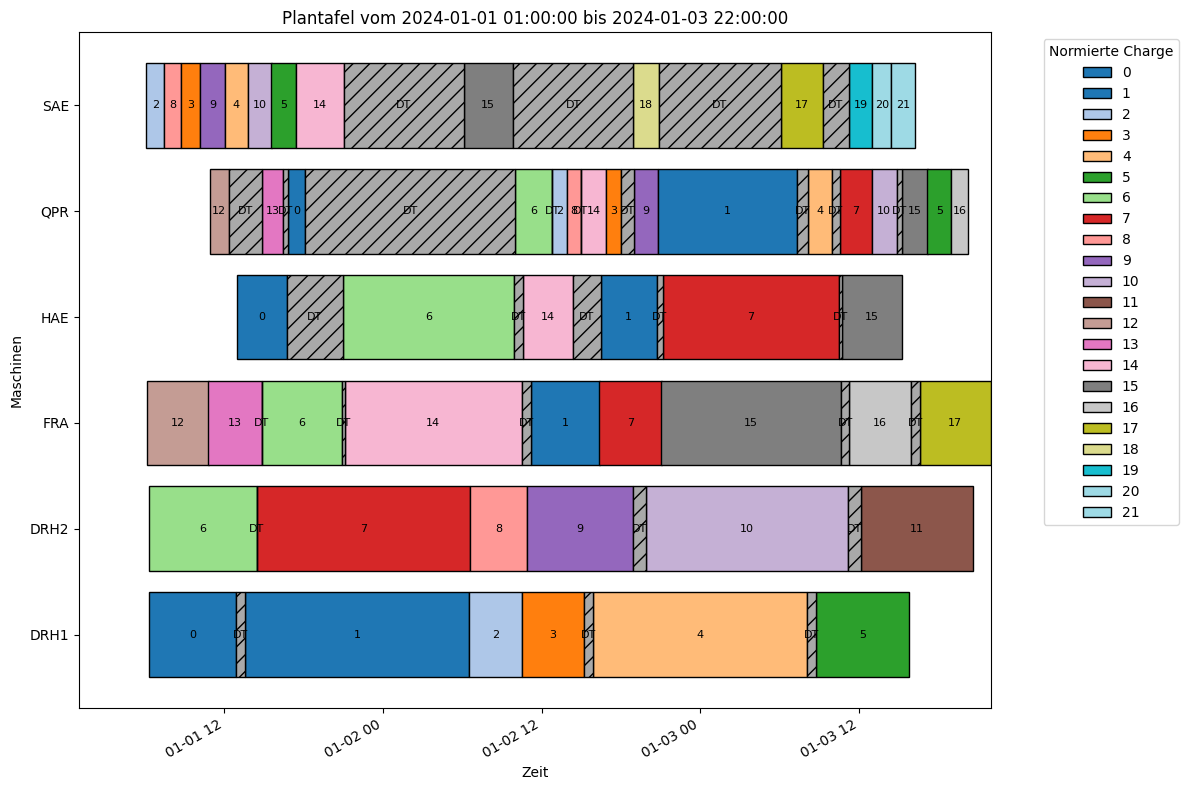

In [3]:
#Plantafel für die Fertigung (ohne Stillstandszeiten)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.patches as patches
import datetime
import sqlite3

#Hier gewünschten Beobachtungszeitraum definieren 
start_vor = "2024-01-01 01:00:00"
ende_vor = "2024-01-03 22:00:00"



# Verbindung zur Datenbank wiederherstellen
conn = sqlite3.connect("prod_data.db")

# Daten aus den relevanten Tabellen abrufen
auftraege_query = """
SELECT a.Charge, a.start_ruesten, a.abtransport, a.bmg
FROM FLF AS a
"""
auftraege_data = pd.read_sql_query(auftraege_query, conn)

# Konvertierung der Zeitstempel in Datetime-Objekte
auftraege_data['start_ruesten'] = pd.to_datetime(auftraege_data['start_ruesten'])
auftraege_data['abtransport'] = pd.to_datetime(auftraege_data['abtransport'])

# Schließen der Verbindung zur Datenbank
conn.close()

#Debugging

#print(auftraege_data)

# Funktion zur Erstellung der Plantafel
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def Plantafel(start_date, end_date, data):
    # Filterung der Daten basierend auf dem gegebenen Zeitraum
    filtered_data = data[
        (data['start_ruesten'] >= pd.Timestamp(start_date)) &
        (data['abtransport'] <= pd.Timestamp(end_date))
    ]
    
    # Sortieren der Daten nach Maschinen und Startzeit
    filtered_data = filtered_data.sort_values(by=['bmg', 'start_ruesten'])
    
    # Normierung der Chargen
    unique_charges = filtered_data['Charge'].unique()
    charge_mapping = {charge: idx for idx, charge in enumerate(unique_charges)}
    filtered_data['Charge_norm'] = filtered_data['Charge'].map(charge_mapping)
    
    # Farben für verschiedene Chargen definieren
    color_map = cm.get_cmap('tab20', len(unique_charges))
    charge_colors = {idx: mcolors.rgb2hex(color_map(i)) for i, idx in enumerate(charge_mapping.values())}
    
    # Berechnung der Stillstandszeiten
    idle_times = []
    for machine, group in filtered_data.groupby('bmg'):
        group = group.sort_values('start_ruesten')
        for i in range(len(group) - 1):
            current_end = group.iloc[i]['abtransport']
            next_start = group.iloc[i + 1]['start_ruesten']
            if current_end < next_start:  # Es gibt eine Lücke
                idle_times.append({
                    'bmg': machine,
                    'start_idle': current_end,
                    'end_idle': next_start
                })
    
    # Gantt-Diagramm erstellen
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, row in filtered_data.iterrows():
        start = row['start_ruesten']
        end = row['abtransport']
        color = charge_colors[row['Charge_norm']]
        ax.barh(row['bmg'], date2num(end) - date2num(start), left=date2num(start),
                color=color, edgecolor='black', label=row['Charge_norm'] if row['Charge_norm'] not in ax.get_legend_handles_labels()[1] else "")
        # Normierte Charge in der Mitte der Balken hinzufügen
        ax.text(date2num(start) + (date2num(end) - date2num(start)) / 2, 
                row['bmg'],  # Vertikale Position basierend auf 'bmg'
                str(row['Charge_norm']), 
                ha='center', va='center', fontsize=8, color='black')
    
    # Stillstandszeiten hinzufügen (mit Schraffur)
    for idle in idle_times:
        start_idle = idle['start_idle']
        end_idle = idle['end_idle']
        ax.barh(idle['bmg'], date2num(end_idle) - date2num(start_idle), left=date2num(start_idle),
                color='darkgray', edgecolor='black', hatch='//', alpha=1)
        ax.text(date2num(start_idle) + (date2num(end_idle) - date2num(start_idle)) / 2, 
                idle['bmg'],  # Vertikale Position basierend auf 'bmg'
                'DT', 
                ha='center', va='center', fontsize=8, color='black')
    
    # Achsen und Titel anpassen
    ax.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Maschinen")
    ax.set_title(f"Plantafel vom {start_date} bis {end_date}")
    ax.xaxis_date()
    fig.autofmt_xdate()
    
    # Legende hinzufügen
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Normierte Charge", loc='upper left', bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

# Aufrauf der Funktion
Plantafel(start_vor, ende_vor, auftraege_data)

